# Mask R-CNN - Inspect the Trained Model (/project/crack)

Visualize and evaluate the prediction results on Mask R-CNN either a random image or testing dataset.

## User input

In [1]:
WEIGHT_PATH = './../../logs/corrosion/corrosion20230322T1123/mask_rcnn_corrosion_0100.h5' #'./../../logs/crack_logs_newloss/crack20211011T1306/mask_rcnn_crack_0200.h5' #'./../../logs/crack_logs_combined_2/crack20210928T1929/mask_rcnn_crack_0300.h5' #'./../../logs/crack_logs_drwon_2/crack20210923T1727/mask_rcnn_crack_0300.h5' #'./../../logs/crack_logs_newcrack500/crack20220214T1558/mask_rcnn_crack_0246.h5'
DATA_NAME = "bianchi"
DATA_DIR_NAME = "dataset/Corrosion_Condition_State_Classification/processed_512/"
SAVE_DIR_NAME = "projects/corrosion/results_outputs/results_"+DATA_NAME

# Set True or False
exposure_adjustment = False # True: w/ exposure adjustment          Flase: w/o exposure adjustment
single_json = True          # True: create single json per image    False: create one json per dataset (not working)
save_image = False          # True: save predicted image            False: do not save predicted image
end_point = True            # True: extract end points only         False: extract every boundary points (ref: https://docs.opencv.org/master

## Import libraries

In [56]:
import os
import sys
import random
import math
import re
import warnings

import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
import cv2
import json
from PIL import Image, ImageEnhance
from skimage import data, img_as_float, exposure
import seaborn as sn
import pandas as pd

from skimage.morphology import skeletonize
from scipy.ndimage import distance_transform_edt
from sklearn.metrics import roc_curve,auc,log_loss,roc_auc_score,confusion_matrix,precision_score,recall_score,f1_score,classification_report, jaccard_similarity_score

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
warnings.filterwarnings('ignore')

In [3]:
import corrosion as project

%matplotlib inline 

# Directory to save logs and trained model
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)
SAVE_DIR = os.path.join(ROOT_DIR, SAVE_DIR_NAME)
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

## Configurations

In [4]:
config = project.Configuration()

# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    #os.environ["CUDA_VISIBLE_DEVICES"]="3"
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

## Notebook Preferences

In [5]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [6]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## GT Visualization

In [7]:
"""Load dataset"""
dataset = project.Datasets()
dataset.load_data(DATA_DIR, "test")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

DATA_SUB_DIR = os.path.join(DATA_DIR, "test")
print(DATA_SUB_DIR)

Images: 44
Classes: ['BG', 'fair', 'poor', 'severe']
/raid/home/toor/Documents/jiyoungl/jupyter/MaskRCNN/MRCNN/dataset/Corrosion_Condition_State_Classification/processed_512/test


In [8]:
"""Load model"""
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
    
"""Load weight"""
weights_path = WEIGHT_PATH

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights  ./../../logs/corrosion/corrosion20230322T1123/mask_rcnn_corrosion_0100.h5






Re-starting from epoch 100


In [9]:
testmodel = model.build(mode="training", config=config)
testmodel.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activatio

In [ ]:
# Create 'result' directory in test folder
print("save segmented result to {}".format(SAVE_DIR))
try:  
    os.mkdir(SAVE_DIR)
except OSError:  
    print ("Creation of the directory %s failed" % SAVE_DIR)
else:  
    print ("Successfully created the directory %s " % SAVE_DIR)

save segmented result to /raid/home/toor/Documents/jiyoungl/jupyter/MaskRCNN/MRCNN/projects/corrosion/results_outputs/results_bianchi
Creation of the directory /raid/home/toor/Documents/jiyoungl/jupyter/MaskRCNN/MRCNN/projects/corrosion/results_outputs/results_bianchi failed


## Make prediction

In [10]:
# Load a random image from the images folder
file_names = next(os.walk(DATA_SUB_DIR))[2]
class_names = ['BG', 'fair', 'poor', 'severe']

fn = file_names
file_names = []
for f in fn:
    if f.endswith(".jpeg"):
        file_names.append(f)

## Measure confusion matrix on merged masks

In [11]:
def measure_conf_mat(mask, gt_mask):
    TP = TN = FP = FN = err = 0
    #total_gt_pixels = sum(sum(gt_mask.astype(np.int16)))[0]
    
    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            if gt_mask[x][y] == mask[x][y]:
                TP += 1
            elif gt_mask[x][y] == False and mask[x][y] == True:
                FP += 1
            elif gt_mask[x][y] == True and mask[x][y] == False:
                FN += 1
            elif gt_mask[x][y] == False and mask[x][y] == False:
                TN += 1
            else:
                err += 1
                
    if err > 0:
        print("error pixels: {}".format(err))
    
    conf_mat = np.array([[TP, FN], [FP, TN]])
    
    if TP == 0:
        precision = 0
        recall = 0
        f_score = 0
    else:
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f_score = 2*precision*recall / (precision+recall)
    
    return conf_mat, precision, recall, f_score

In [12]:
def visualize_each_class(mask, class_id):
    tmp = np.zeros(mask.shape[:2])
    for dim in range(mask.shape[2]):
        idx = np.where(mask[:,:,dim] == class_id)
        tmp[idx] = class_id
        
    return tmp

def visualize_overlay(mask):
    tmp = np.zeros(mask.shape[:2]);
    if mask.shape[2] > 0:
        for dim in range(mask.shape[2]):
            idx = np.where(mask[:,:,dim] > 0)
            tmp_ = np.unique(mask[:,:,dim])
            if len(tmp_) > 1:
                tmp[idx] = tmp_[1]
        
    return tmp

def confusion_matrix_2d(true, pred, label):
    
    true_arr = np.reshape(true, (true.shape[0]*true.shape[1], 1))
    pred_arr = np.reshape(pred, (pred.shape[0]*pred.shape[1], 1))

    return confusion_matrix(true_arr, pred_arr, labels=label), classification_report(true_arr, pred_arr, labels=label, target_names=['BG', 'poor', 'fair', 'severe'])

### Option 1. Run on one random test image

In [121]:
'''
(Option 1) Run on one random test image
'''
class Predict_One_Image:
    
    def __init__(self, save=True, show=True):
        self.save = save
        self.show = show
        self.json = False
        self.image_id = 0
        self.file_name = ""
        self.true_mask = 0
        self.pred_mask = 0
        self.image = ""

    '''
    #### 1-1. Run on original prediction results
    '''
    def predict_one_random_image(self, image_id, image_name):
        
        if image_name is not "":
            file_name = image_name
            image = cv2.imread(os.path.join(DATA_SUB_DIR, file_name))
            gt_mask = np.load(os.path.join(DATA_SUB_DIR, file_name)[:-5]+".npy")
            
        else:
            if image_id == 9999:
                self.image_id = random.choice(dataset.image_ids)
            else:
                self.image_id = image_id

            image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, self.image_id, use_mini_mask=False)
            info = dataset.image_info[self.image_id]
            file_name = info["id"]
        print(f"image: {file_name}")

        results = model.detect([image], verbose=0)
        r = results[0]
        
        # Update variables
        self.file_name = file_name
        self.true_mask = gt_mask.astype(np.int32) * gt_class_id
        self.pred_mask = r['masks'].astype(np.int32) * r['class_ids']
        self.image = image
        
    
    '''
    #### 1-2. Visualize each class results
    '''
    def class_prediction_results(self):

        file_name = self.file_name
        gt_mask = self.true_mask
        r_mask = self.pred_mask
        colormap = "cool"
        alpha=0.5
        classes = ['original', 'fair', 'poor', 'severe']
        
        # visualize 4x2 
        if self.show:
            plt.figure(figsize = (20,10), facecolor='white', dpi=150)
            c = 1
            for row in range(1,2+1):
                for col in range(1,4+1):
                    if row == 1: #gt
                        plt.subplot(2,4,c)
                        plt.imshow(self.image)
                        
                        if col == 1:
                            tmp = visualize_overlay(gt_mask)
                            plt.ylabel('true', color='r', fontsize=12)
                        else:
                            tmp = visualize_each_class(gt_mask, col-1)
                            
                        plt.imshow(tmp, alpha=alpha*(tmp>0), interpolation='nearest', cmap=colormap)
                        plt.xticks([])
                        plt.yticks([])
                        plt.title(f'class: \'{classes[col-1]}\'', fontsize=12)
                        
                    else: #pred
                        plt.subplot(2,4,c)
                        plt.imshow(self.image)
                        if col == 1:
                            tmp = visualize_overlay(r_mask)
                            plt.ylabel('pred', color='b', fontsize=12)                            
                        else:
                            tmp = visualize_each_class(r_mask, col-1)
                        plt.imshow(tmp, alpha=alpha*(tmp>0), interpolation='nearest', cmap=colormap)
                        plt.xticks([])
                        plt.yticks([])
                        
                    c+=1  

    '''
    Implements Smooth-L1 loss.
    y_true and y_pred are typically: [N, 4], but could be any shape.
    '''
    def smooth_l1_loss(self, y_true, y_pred):
        diff = abs(y_true - y_pred)
        less_than_one = np.where(diff < 1.0, 1, 0).astype(np.float32)
        loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
        
        return loss
    
    def root_mean_squared_errors(self, ax, y_true, y_pred):
        return np.sqrt((np.square(y_true - y_pred)).mean(axis=ax))

image: 0.jpeg
[[171261   1881     28      0]
 [ 42907  21329   5276      0]
 [ 15317   1223   2922      0]
 [     0      0      0      0]]
              precision    recall  f1-score   support

          BG       0.75      0.99      0.85    173170
        poor       0.87      0.31      0.45     69512
        fair       0.36      0.15      0.21     19462
      severe       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75    262144
   macro avg       0.49      0.36      0.38    262144
weighted avg       0.75      0.75      0.70    262144



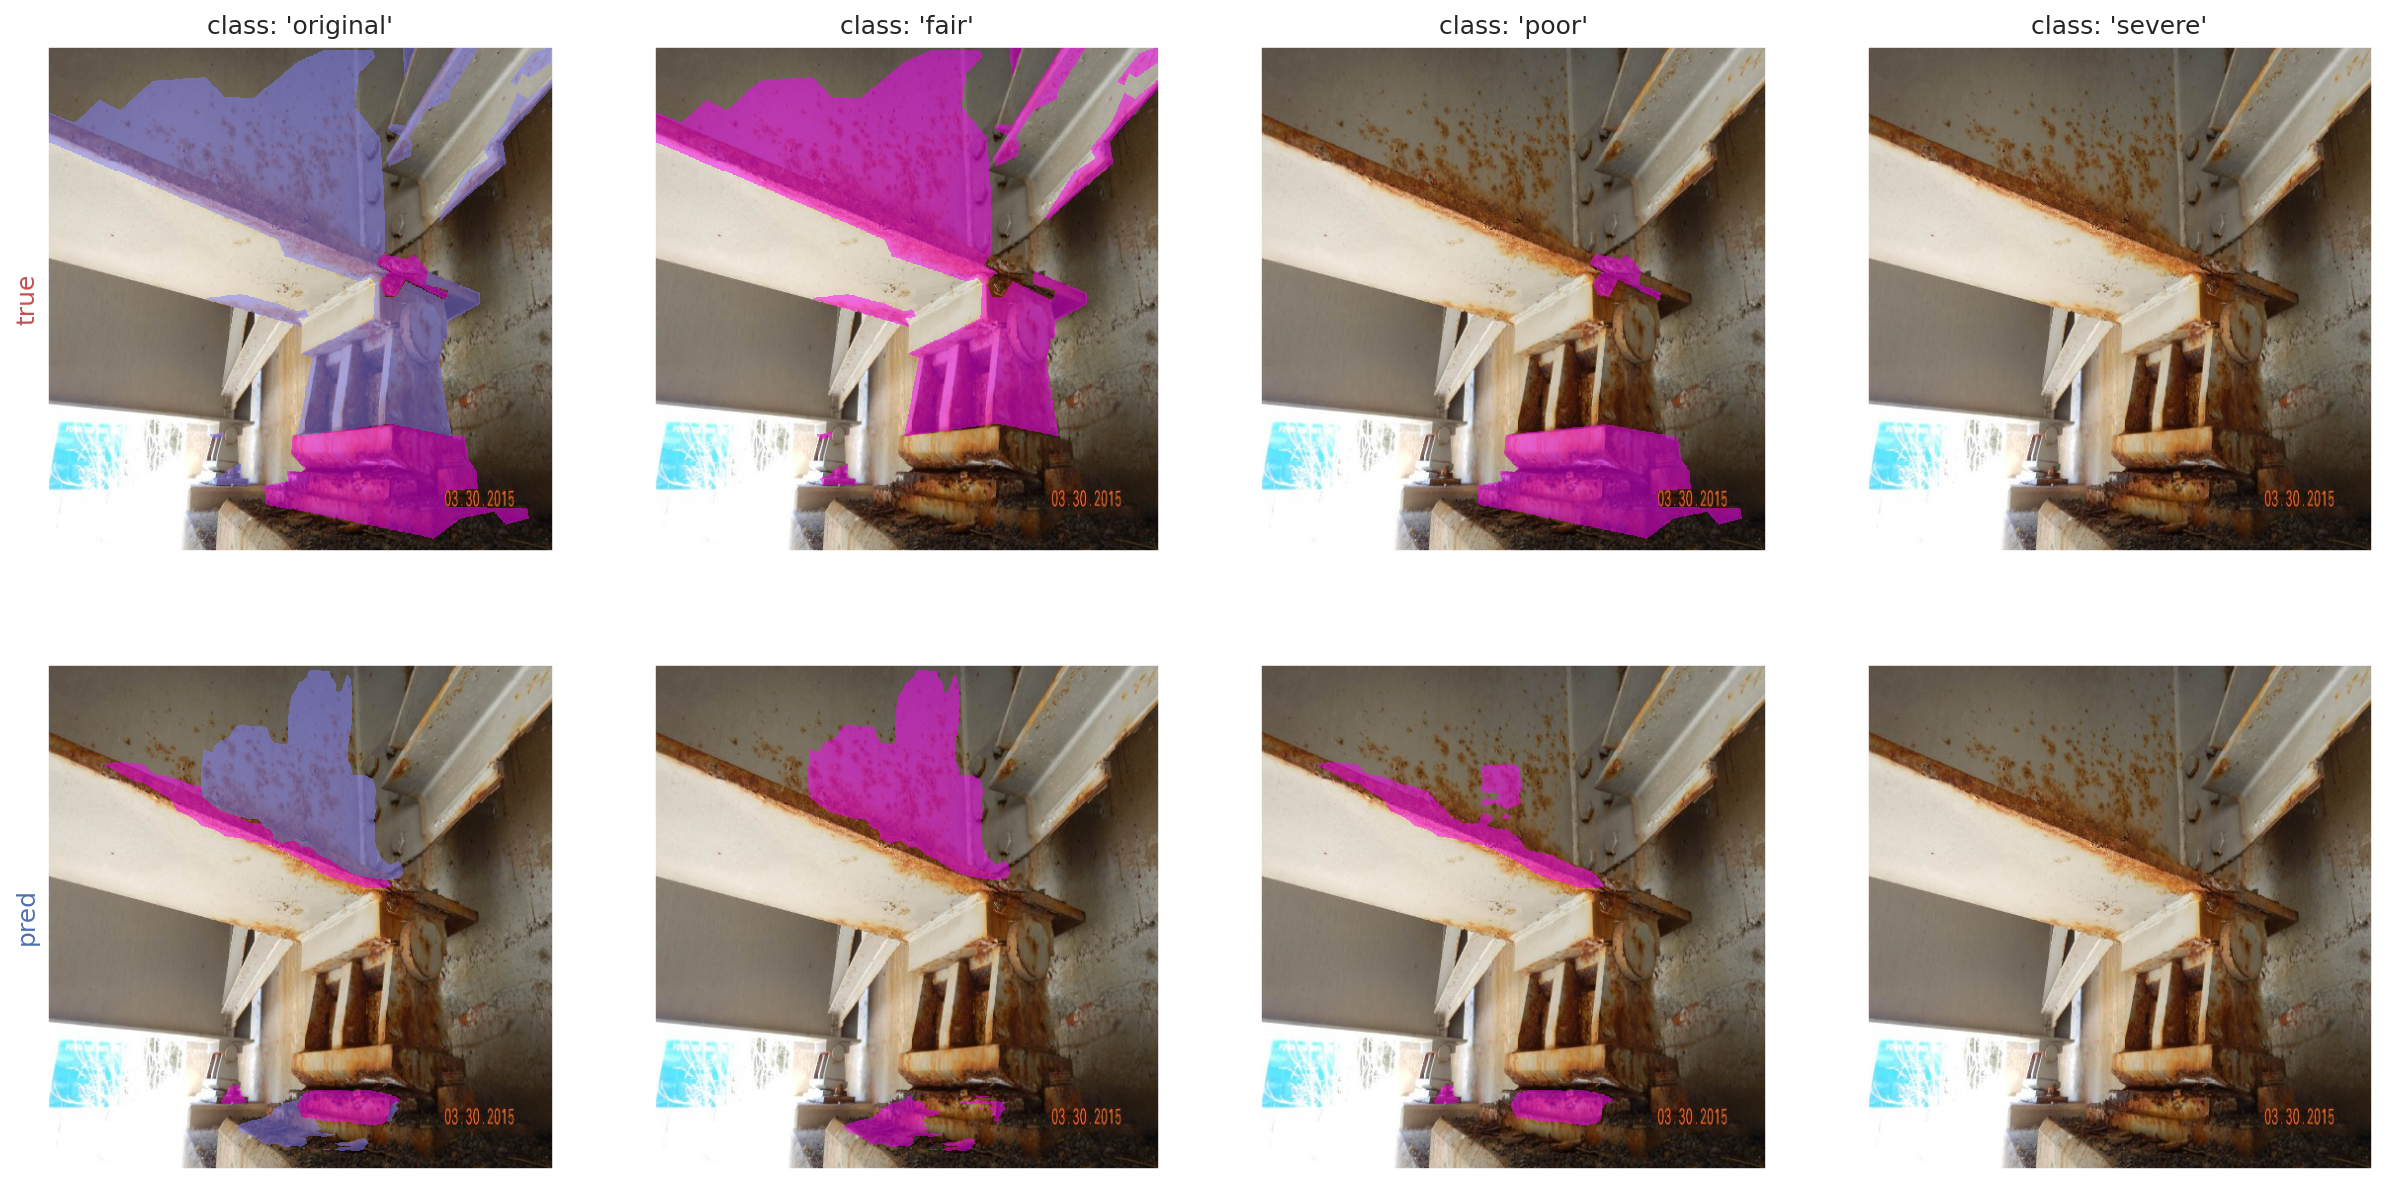

In [126]:
test_one = Predict_One_Image(save=True, show=True)
f = "" 

test_one.predict_one_random_image(9999, f) # 9999 for random, idx otherwise
test_one.class_prediction_results()

if f == "":
    f = test_one.file_name    
    
mat, report = confusion_matrix_2d(visualize_overlay(test_one.true_mask).astype(np.int32), visualize_overlay(test_one.pred_mask).astype(np.int32), [0,1,2,3])
print(mat)
print(report)

In [127]:
# true if two masks overlapped more than threshold
# otherwise false
# check for each class
# th = 0 : at least one pixel detected as target class
# th = 0.5 : true and pred masks are overlapped more than 50%

def evaluate_map(true, pred, th):
    scores = []
    cnum = 4
    
    # for each class:
    #     if true and pred overlapped > th:
    #         score.class = 1
    #     else:
    #         score.class = 0    
    
    for c in range(1,cnum):
        c_true = visualize_each_class(true, c)
        c_true_f = np.reshape(c_true, (c_true.shape[0]*c_true.shape[1], 1))
        c_pred = visualize_each_class(pred, c)
        c_pred_f = np.reshape(c_pred, (c_pred.shape[0]*c_pred.shape[1], 1))
        
        # print(c_true_f.shape, c_pred_f.shape)
        # print(np.unique(c_true_f))
        # print(np.unique(c_pred_f))
        
        # tp = np.sum(c_true_f * c_pred_f)
        # p = np.sum(np.clip((c_true_f + c_pred_f), 0,1))
        # iou = jaccard_similarity_score(c_true_f, c_pred_f)
        # print(f'for {c} iou {iou}')
        # pre = precision_score(np.clip(c_true_f,0,1), np.clip(c_pred_f,0,1))
        # print(f'for {c} pre {pre}')
        
        # scores.append(1) if iou > th else scores.append(0)
        
        if (np.sum(c_true) > 1) and (np.sum(c_pred) > 1) or (np.sum(c_true) == 0) and (np.sum(c_pred) == 0):
            scores.append(1)
        else:
            scores.append(0)
    
    return np.array(scores)

score = evaluate_map(test_one.true_mask, test_one.pred_mask, 0)
print(score)

[1 1 1]


In [83]:
score1 = np.array([1 0 1])
score2 = np.array([1 1 1])
np.sum(score1,score2)

SyntaxError: invalid syntax (<ipython-input-83-43a8c63f778d>, line 1)

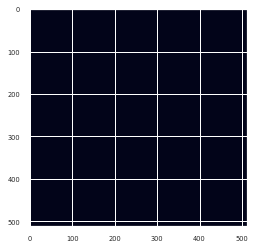

In [70]:
plt.imshow(np.clip(visualize_each_class(test_one.true_mask, 3),0,1))

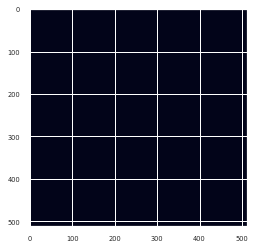

In [71]:
plt.imshow(np.clip(visualize_each_class(test_one.pred_mask, 3),0,1))

In [57]:
!pip show scikit-learn

Name: scikit-learn
Version: 0.20.3
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /home/toor/anaconda3/envs/dp/lib/python3.6/site-packages
Requires: numpy, scipy
Required-by: qudida


In [25]:
test_one.pred_mask.shape

(512, 512, 5)

In [41]:
np.unique(test_one.pred_mask[:,:,3])

array([0, 2], dtype=int32)

Text(0.5, 32.87499999999999, 'pred')

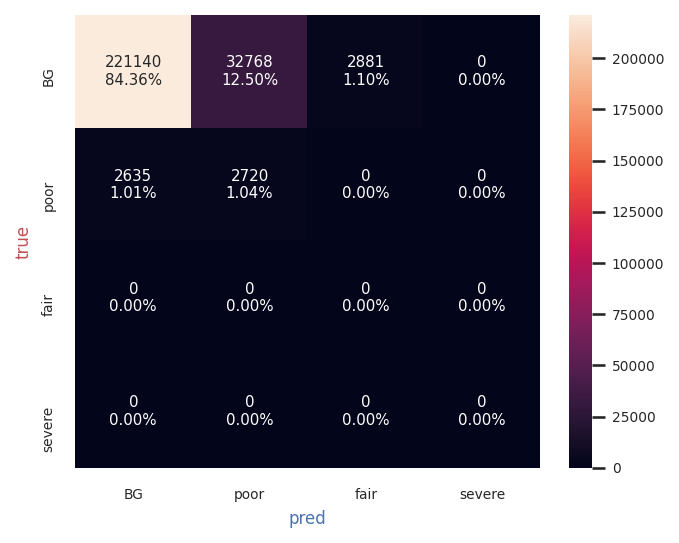

In [15]:
group_counts = ['{0:0.0f}'.format(value) for value in mat.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in mat.flatten()/np.sum(mat)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(4,4)

axis_labels = ['BG', 'fair', 'poor', 'severe']

plt.figure(figsize = (5,4), facecolor='white', dpi=150)
sn.set(font_scale=0.6)
ax = sn.heatmap(mat, annot=labels, fmt='', xticklabels=axis_labels, yticklabels=axis_labels)
ax.set_ylabel('true', color='r', fontsize=8)
ax.set_xlabel('pred', color='b', fontsize=8)

## Evaluation

#### (Option 1.) AP score based on IoU thresholds (0.5 & 0.75) -- for instance segmented masks only

In [ ]:
"""Get accuracy metrics"""

list_50 = []
list_75 = []

# for i in tqdm(range(len(file_names))):
for i in range(len(file_names)):
    image_id = i
    image, image_meta, gt_class_id, gt_bbox, gt_mask =modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    
    mAP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'], iou_threshold=0.5)
    list_50.append([mAP, precisions, recalls])
    
    mAP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'], iou_threshold=0.75)
    list_75.append([mAP, precisions, recalls])

print("AP@.50: {}".format( np.mean( np.array(list_50)[:,0] )))
print("AP@.75: {}".format( np.mean( np.array(list_75)[:,0] )))

#### (Option 2.) Confusion matrix for pixel-level comparison -- for merged segmented masks only

In [128]:
conf_mat = np.zeros((4,4)).astype(np.int16)
img_count = 0
Precision = []
Recall = []
FScore = []
label = [0,1,2,3]
target = ['BG', 'fair', 'poor', 'severe']

for i in tqdm(range(len(file_names))):
    image_id = i
    
    try:
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    except:
        continue
        
    results = model.detect([image], verbose=0)
    r = results[0]
    
    true = visualize_overlay(gt_mask.astype(np.int32) * gt_class_id)
    pred = visualize_overlay(r['masks'].astype(np.int32) * r['class_ids'])
    
    true_arr = np.reshape(true, (true.shape[0]*true.shape[1], 1))
    pred_arr = np.reshape(pred, (pred.shape[0]*pred.shape[1], 1))
    
    # Measure confusion matrix
    # conf_mat = conf_mat + confusion_matrix(true_arr, pred_arr, labels=label)
    Precision.append(precision_score(true_arr, pred_arr, labels=label, average='weighted'))
    Recall.append(recall_score(true_arr, pred_arr, labels=label, average='weighted'))
    FScore.append(f1_score(true_arr, pred_arr, labels=label, average='weighted'))
    # classification_report(true_arr, pred_arr, labels=label, target_names=target)

  9%|▉         | 4/44 [00:02<00:21,  1.85it/s]


KeyboardInterrupt: 

In [129]:
Precision

[0.5333643668689176, 0.814865772371421, 0.5534360306399299, 0.650205762250976]

In [110]:
conf_mat

array([[8495219,  392269,  178614,   11895],
       [ 864669,  356703,  207552,   23317],
       [ 424767,   76515,  315572,   24297],
       [  70784,   15072,   61335,   15756]])

In [137]:
model_name = os.path.split(os.path.split(weights_path)[0])[1]

print("Model \n : {}".format(model_name))
print("Average \n - Precision: {:.4f}\n - Recall: {:.4f}\n - F-score: {:.4f}".format(np.mean(Precision), np.mean(Recall), np.mean(FScore))) 

Model 
 : corrosion20230322T1123
Average 
 - Precision: 0.8021
 - Recall: 0.7962
 - F-score: 0.7773


In [116]:
Scores = 0

for i in tqdm(range(len(file_names))):
    image_id = i
    
    try:
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    except:
        continue
        
    results = model.detect([image], verbose=0)
    r = results[0]
    
    true = gt_mask.astype(np.int32) * gt_class_id
    pred = r['masks'].astype(np.int32) * r['class_ids']
    
    score = evaluate_map(true, pred, 0)
    # Scores.append(score)
    Scores = Scores + score
        
print(Scores / len(file_names))

100%|██████████| 44/44 [00:10<00:00,  4.14it/s]

[0.90909091 0.81818182 0.77272727]


In [119]:
mat = np.array([[8495219,  392269,  178614,   11895],
                [ 864669,  356703,  207552,   23317],
                [ 424767,   76515,  315572,   24297],
                [  70784,   15072,   61335,   15756]])

mat

array([[8495219,  392269,  178614,   11895],
       [ 864669,  356703,  207552,   23317],
       [ 424767,   76515,  315572,   24297],
       [  70784,   15072,   61335,   15756]])

In [120]:
356703 / (356703+76515+15072)

0.7956969818644182

In [134]:
def evaluate_per_class_score(true, pred):
    scores = []
    cnum = 4
    
    for c in range(1,cnum):
        c_true = visualize_each_class(true, c)
        c_true_f = np.reshape(c_true, (c_true.shape[0]*c_true.shape[1], 1))
        c_pred = visualize_each_class(pred, c)
        c_pred_f = np.reshape(c_pred, (c_pred.shape[0]*c_pred.shape[1], 1))
        
        tp = np.sum(c_true_f * c_pred_f)
        p = np.sum(np.clip((c_true_f + c_pred_f), 0,1))
        pre = precision_score(np.clip(c_true_f,0,1), np.clip(c_pred_f,0,1))
        # print(f'for {c} pre {pre}')
        scores.append(pre)
        
    return np.array(scores)

score = evaluate_per_class_score(test_one.true_mask, test_one.pred_mask)
print(score)

[0.85183854 0.25868421 0.        ]


In [135]:
Scores = 0

for i in tqdm(range(len(file_names))):
    image_id = i
    
    try:
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    except:
        continue
        
    results = model.detect([image], verbose=0)
    r = results[0]
    
    true = gt_mask.astype(np.int32) * gt_class_id
    pred = r['masks'].astype(np.int32) * r['class_ids']
    
    score = evaluate_per_class_score(true, pred)
    # Scores.append(score)
    Scores = Scores + score
        
print(Scores / len(file_names))

100%|██████████| 44/44 [00:18<00:00,  2.33it/s]

[0.353729   0.33985283 0.00857459]
